In [8]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use(r'mplstyle')

import matplotlib as mpl
import pandas as pd
from sklearn.svm import SVC
from sklearn.utils import resample
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from scipy.optimize import minimize
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fed9ae', '#fbad54']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [9]:
def fit_svc(data, label):
    svc = SVC(kernel = 'linear', class_weight = 'balanced')
    svc.fit(data, label)
    w = svc.coef_[0]           # w consists of 2 elements
    a = - svc.intercept_[0] / w[1]
    b = - w[0] / w[1] 
    return a, b

def analyse_loglog_data(xx, yy, label, repeats = 50, nsample = 5000):
    # fit power law
    lnx = np.log10(xx)
    lny = np.log10(yy)
    data = np.array([lnx, lny]).T
    
    molar_ratio = []
    B = []
    A = []
    for _ in range(repeats):
        print(_, end = '\r')
        data_resampled, label_resampled = resample(data, label, replace = True, n_samples = min(nsample, len(data)))
        a, b = fit_svc(data_resampled, label_resampled)
        # a, b = fit_crosstalk(data_resampled, label_resampled, x0 = [b, a])
        molar_ratio.append(-1/b)
        B.append(b)
        A.append(a)
    molar_ratio_avg = np.mean(molar_ratio)
    molar_ratio_std = np.std(molar_ratio)
    B_avg = np.mean(B)
    B_std = np.std(B)
    A_avg = np.mean(A)
    A_std = np.std(A)
    
    return [molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std]

def plot_loglog_data(fig, axes, xx, yy, cc, xlim_lin, xlim_log, ylim_lin, ylim_log, xlabel, ylabel, res):
    [molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std] = res
    
    axes.scatter(xx, yy, c = cc, s = 2)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    
    x_fit = np.linspace(1e-2, 1e2, 1000)
    y_fit_avg = 10 ** A_avg * x_fit ** B_avg
    y_fit_iter = []
    for _1 in [-1, +1]:
        for _2 in [-1, +1]:
            y_fit_iter.append(10 ** (A_avg + _1 * A_std) * x_fit ** (B_avg + _2 * B_std))
    y_fit_max = np.max(y_fit_iter, axis = 0)
    y_fit_min = np.min(y_fit_iter, axis = 0)
    
    axes.plot(x_fit, y_fit_avg, color = 'black', lw = 1)
    axes.plot(x_fit, y_fit_min, color = 'black', lw = 1, linestyle = 'dashed')
    axes.plot(x_fit, y_fit_max, color = 'black', lw = 1, linestyle = 'dashed')
    # axes.fill_between(x_fit, y_fit_min, y_fit_max, color = 'black', alpha = 0.1, linewidth = 0)

    axes.set_xscale('log')
    axes.set_yscale('log')

    axes.set_xlim(*xlim_log)
    axes.set_ylim(*ylim_log)

    ax_inset = inset_axes(axes, width="70%", height="70%", loc=3, bbox_to_anchor=(.23, .19, .6, .6),
                   bbox_transform=axes.transAxes)
    
    ax_inset.scatter(xx, yy, c = cc, s = 2)
    ax_inset.plot(x_fit, y_fit_avg, color = 'black', lw = 1)
    # ax_inset.fill_between(x_fit, y_fit_min, y_fit_max, color = 'black', alpha = 0.1)
    ax_inset.plot(x_fit, y_fit_min, color = 'black', lw = 1, linestyle = 'dashed')
    ax_inset.plot(x_fit, y_fit_max, color = 'black', lw = 1, linestyle = 'dashed')

    ax_inset.set_xlim(*xlim_lin)
    ax_inset.set_ylim(*ylim_lin)
    ax_inset.set_xlabel(xlabel)
    ax_inset.set_ylabel(ylabel)
    ax_inset.set_xticks(np.linspace(*xlim_lin, 3))
    ax_inset.set_yticks(np.linspace(*ylim_lin, 3))
    
    # axes[0].annotate(r'$\frac{q^{\text{FUS(G156E)}}}{q^{\text{PEG6k}}}\approx0.56$', xy=(2e-1,3e0))

In [10]:
dfs = []
key = []
lab = []
subtitles = ['wild type', 'mutant', 'mutant + bis-ANS']

dfs.append(pd.read_csv('../data/FUS_data.csv').sample(frac = 1))
key.append([r'PEG / %', r'FUS / uM'])
lab.append([r'[PEG](\%)', r'[FUS]($\upmu$M)'])

_df = pd.read_csv('../data/FUS_bA_data.csv').sample(frac = 1).dropna()
dfs.append(_df[_df['bis-ANS'] == 0])
key.append([r'PEG 6000 / % (w/w)', r'FUS(G156E)-EGFP / μM'])
lab.append([r'[PEG](\%)', r'[FUS(G156E)]($\upmu$M)'])

dfs.append(_df[_df['bis-ANS'] == 1])
key.append([r'PEG 6000 / % (w/w)', r'FUS(G156E)-EGFP / μM'])
lab.append([r'[PEG](\%)', r'[FUS(G156E)]($\upmu$M)'])

In [11]:
RES = []
for i in range(len(dfs)):
    df = dfs[i]
    _x = df[key[i][0]].values
    _y = df[key[i][1]].values
    _p = df['feature'].values
    if i == 0:
        mask = _x > 3 # the low-PEG data biases the SVC to give a poor fit, so remove them here
        res = analyse_loglog_data(_x[mask], _y[mask], _p[mask], repeats = 50, nsample = 1500)
    else:
        res = analyse_loglog_data(_x, _y, _p, repeats = 50, nsample = 800)
    print(r'molar ratio of {0} against {1} is {2:.3f}+-{3:.3f}'.format(lab[i][1], lab[i][0], res[0], res[1]))
    RES.append([_x, _y, _p, res])

molar ratio of [FUS]($\upmu$M) against [PEG](\%) is 0.105+-0.009
molar ratio of [FUS(G156E)]($\upmu$M) against [PEG](\%) is 0.552+-0.032
molar ratio of [FUS(G156E)]($\upmu$M) against [PEG](\%) is 1.102+-0.073


/var/folders/1f/jb5kg1hx3bx_jz_8xhp9fbym0000gn/T/ipykernel_5788/4118636821.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


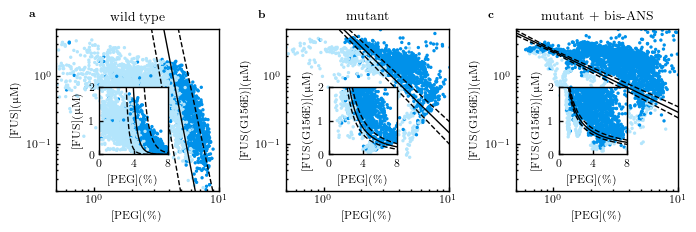

In [12]:
fig, axes = plt.subplots(1, 3, figsize = cm2inch(17.8, 6))

xlim_lin = [0, 8]
xlim_log = [5e-1, 1e1]

ylim_lin = [0, 2]
ylim_log = [2e-2, 5e0]

for i in range(3):
    _x, _y, _p, res = RES[i]
    _c = [colors[0][i] for i in _p.astype(int)]
    plot_loglog_data(fig, axes[i], _x, _y, _c, xlim_lin, xlim_log, ylim_lin, ylim_log, lab[i][0], lab[i][1], res)
    axes[i].set_title(subtitles[i])
axes[0].text(0.0, 1.0, r'\textbf{a}',
             transform = (axes[0].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
             va='bottom')

axes[1].text(0.0, 1.0, r'\textbf{b}',
             transform = (axes[1].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
             va='bottom')

axes[2].text(0.0, 1.0, r'\textbf{c}',
             transform = (axes[2].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
             va='bottom')

plt.tight_layout()